In [1]:
import json
import torch
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")


/root/miniconda/envs/openvla/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths to your JSON datasets
out_set_path = '/root/vla-clip/openvla/experiments/robot/libero/libero_rephrase_out_set.json'
hard_path = '/root/vla-clip/openvla/experiments/robot/libero/libero_rephrase_hard.json'

# Define the 5 tasks that have rollout data (from rollouts_ood_oracle/rephrase_25)
ROLLOUT_TASKS = [
    'pick up the black bowl next to the cookie box and place it on the plate',
    'pick up the black bowl next to the plate and place it on the plate', 
    'pick up the black bowl on the ramekin and place it on the plate',
    'pick up the black bowl on the stove and place it on the plate',
    'pick up the black bowl on the wooden cabinet and place it on the plate'
]

def normalize_task_name(task):
    """Normalize task names for matching between datasets."""
    import re
    return re.sub(r'\s+', ' ', task.strip().lower())

# Load both datasets
print("Loading datasets...")
with open(out_set_path, 'r') as f:
    out_set_data = json.load(f)

with open(hard_path, 'r') as f:
    hard_data = json.load(f)

# Extract ALL instructions first
all_originals = []
all_out_set_rephrases = []
all_hard_rephrases = []
all_three_way_pairs = []  # (original, [out_set_rephrases], [hard_rephrases])

for group_name in out_set_data.keys():
    print(f"Processing group: {group_name}")
    
    # Process out-set data
    out_set_group = out_set_data[group_name]
    hard_group = hard_data[group_name]
    
    for idx in out_set_group.keys():
        if idx in hard_group:  # Make sure both datasets have this instruction
            orig = out_set_group[idx]['original']
            out_set_reps = out_set_group[idx]['rephrases']
            hard_reps = hard_group[idx]['rephrases']
            
            all_originals.append(orig)
            all_out_set_rephrases.extend(out_set_reps)
            all_hard_rephrases.extend(hard_reps)
            all_three_way_pairs.append((orig, out_set_reps, hard_reps))

print(f'Found {len(all_originals)} total originals in datasets')

# Filter to only the 5 tasks that have rollout data
print(f"\n🎯 Filtering to only the {len(ROLLOUT_TASKS)} tasks with rollout data...")

# Normalize rollout task names for matching
normalized_rollout_tasks = [normalize_task_name(task) for task in ROLLOUT_TASKS]

# Filter to matching tasks only
originals = []
out_set_rephrases = []
hard_rephrases = []
three_way_pairs = []

for i, orig in enumerate(all_originals):
    normalized_orig = normalize_task_name(orig)
    
    if normalized_orig in normalized_rollout_tasks:
        orig_pair = all_three_way_pairs[i]
        originals.append(orig)
        out_set_rephrases.extend(orig_pair[1])  # out_set_reps
        hard_rephrases.extend(orig_pair[2])     # hard_reps
        three_way_pairs.append(orig_pair)

print(f'✅ Filtered to {len(originals)} originals with rollout data')
print(f'✅ Total out-set rephrases: {len(out_set_rephrases)}')
print(f'✅ Total hard rephrases: {len(hard_rephrases)}')
print(f'✅ Total three-way pairs: {len(three_way_pairs)}')
print(f'✅ Average out-set rephrases per original: {len(out_set_rephrases)/len(originals):.1f}')
print(f'✅ Average hard rephrases per original: {len(hard_rephrases)/len(originals):.1f}')

print(f"\n📋 Filtered tasks:")
for i, orig in enumerate(originals):
    print(f"   {i+1}. {orig}")


Loading datasets...
Processing group: libero_spatial
Processing group: libero_10
Found 20 total originals in datasets

🎯 Filtering to only the 5 tasks with rollout data...
✅ Filtered to 5 originals with rollout data
✅ Total out-set rephrases: 125
✅ Total hard rephrases: 125
✅ Total three-way pairs: 5
✅ Average out-set rephrases per original: 25.0
✅ Average hard rephrases per original: 25.0

📋 Filtered tasks:
   1. pick up the black bowl on the ramekin and place it on the plate
   2. pick up the black bowl next to the cookie box and place it on the plate
   3. pick up the black bowl on the stove and place it on the plate
   4. pick up the black bowl next to the plate and place it on the plate
   5. pick up the black bowl on the wooden cabinet and place it on the plate


In [3]:
# Initialize BERT (same as used in the verifier)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

print("Loading BERT model...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)
model.eval()

def get_bert_embedding(text, max_length=77):
    """Get BERT [CLS] token embedding for a text"""
    with torch.no_grad():
        inputs = tokenizer(
            text, 
            return_tensors='pt', 
            truncation=True, 
            max_length=max_length, 
            padding='max_length'
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs)
        # Use [CLS] token embedding (first token)
        return outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()

print("BERT model loaded successfully!")


Using device: cuda
Loading BERT model...
BERT model loaded successfully!


In [4]:
# Compute embeddings for all texts
all_texts = originals + out_set_rephrases + hard_rephrases
all_labels = (['original'] * len(originals) + 
              ['out_set'] * len(out_set_rephrases) + 
              ['hard'] * len(hard_rephrases))

print("Computing BERT embeddings...")
embeddings = []
for text in tqdm(all_texts, desc='Embedding texts'):
    emb = get_bert_embedding(text)
    embeddings.append(emb)

embeddings = np.stack(embeddings)
print(f"Computed {len(embeddings)} embeddings of dimension {embeddings.shape[1]}")
print(f"Breakdown: {len(originals)} originals, {len(out_set_rephrases)} out-set, {len(hard_rephrases)} hard")


Computing BERT embeddings...


Embedding texts: 100%|██████████| 255/255 [00:02<00:00, 100.79it/s]

Computed 255 embeddings of dimension 768
Breakdown: 5 originals, 125 out-set, 125 hard


Applying t-SNE...


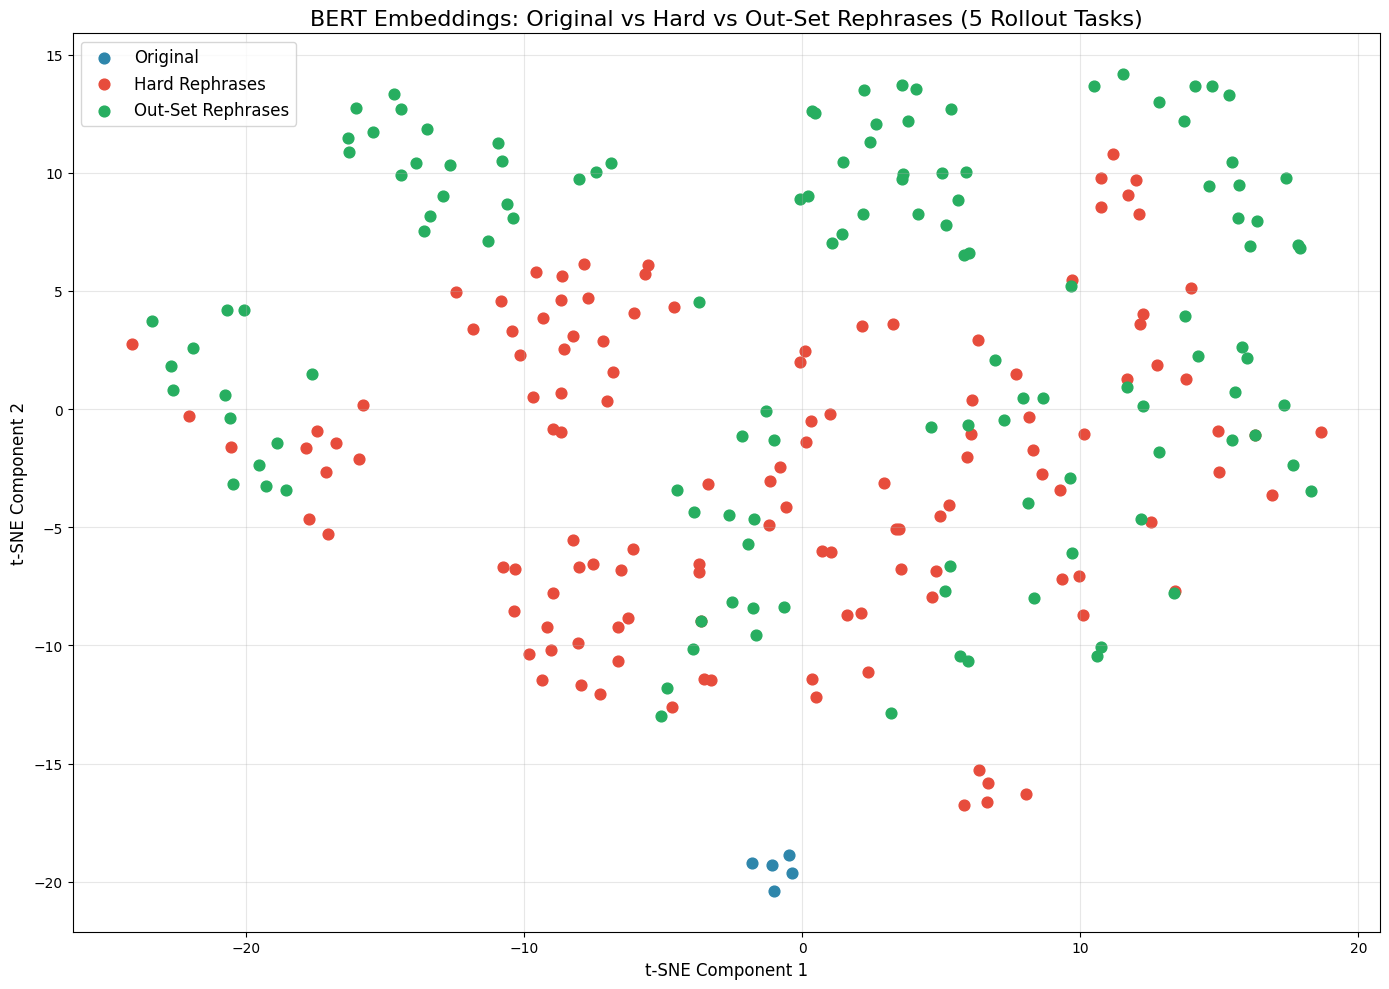

Plotted 5 originals, 125 hard rephrases, 125 out-set rephrases


In [13]:
# Apply t-SNE to all embeddings
print("Applying t-SNE...")
perplexity = min(30, len(embeddings) // 3)  # Adjust perplexity based on data size
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000)
emb_2d = tsne.fit_transform(embeddings)

# Create the three-way plot
plt.figure(figsize=(14, 10))
colors = ['#2E86AB', '#E74C3C', '#27AE60']  # Blue for original, Red for hard, Green for out-set
labels = ['original', 'hard', 'out_set']
label_names = ['Original', 'Hard Rephrases', 'Out-Set Rephrases']

for i, (label, name) in enumerate(zip(labels, label_names)):
    mask = np.array(all_labels) == label
    plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], 
                c=colors[i], label=name, 
                alpha=1, s=60)

plt.title('BERT Embeddings: Original vs Hard vs Out-Set Rephrases (5 Rollout Tasks)', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Plotted {len(originals)} originals, {len(hard_rephrases)} hard rephrases, {len(out_set_rephrases)} out-set rephrases")


Showing all 5 rollout task three-way pairs...


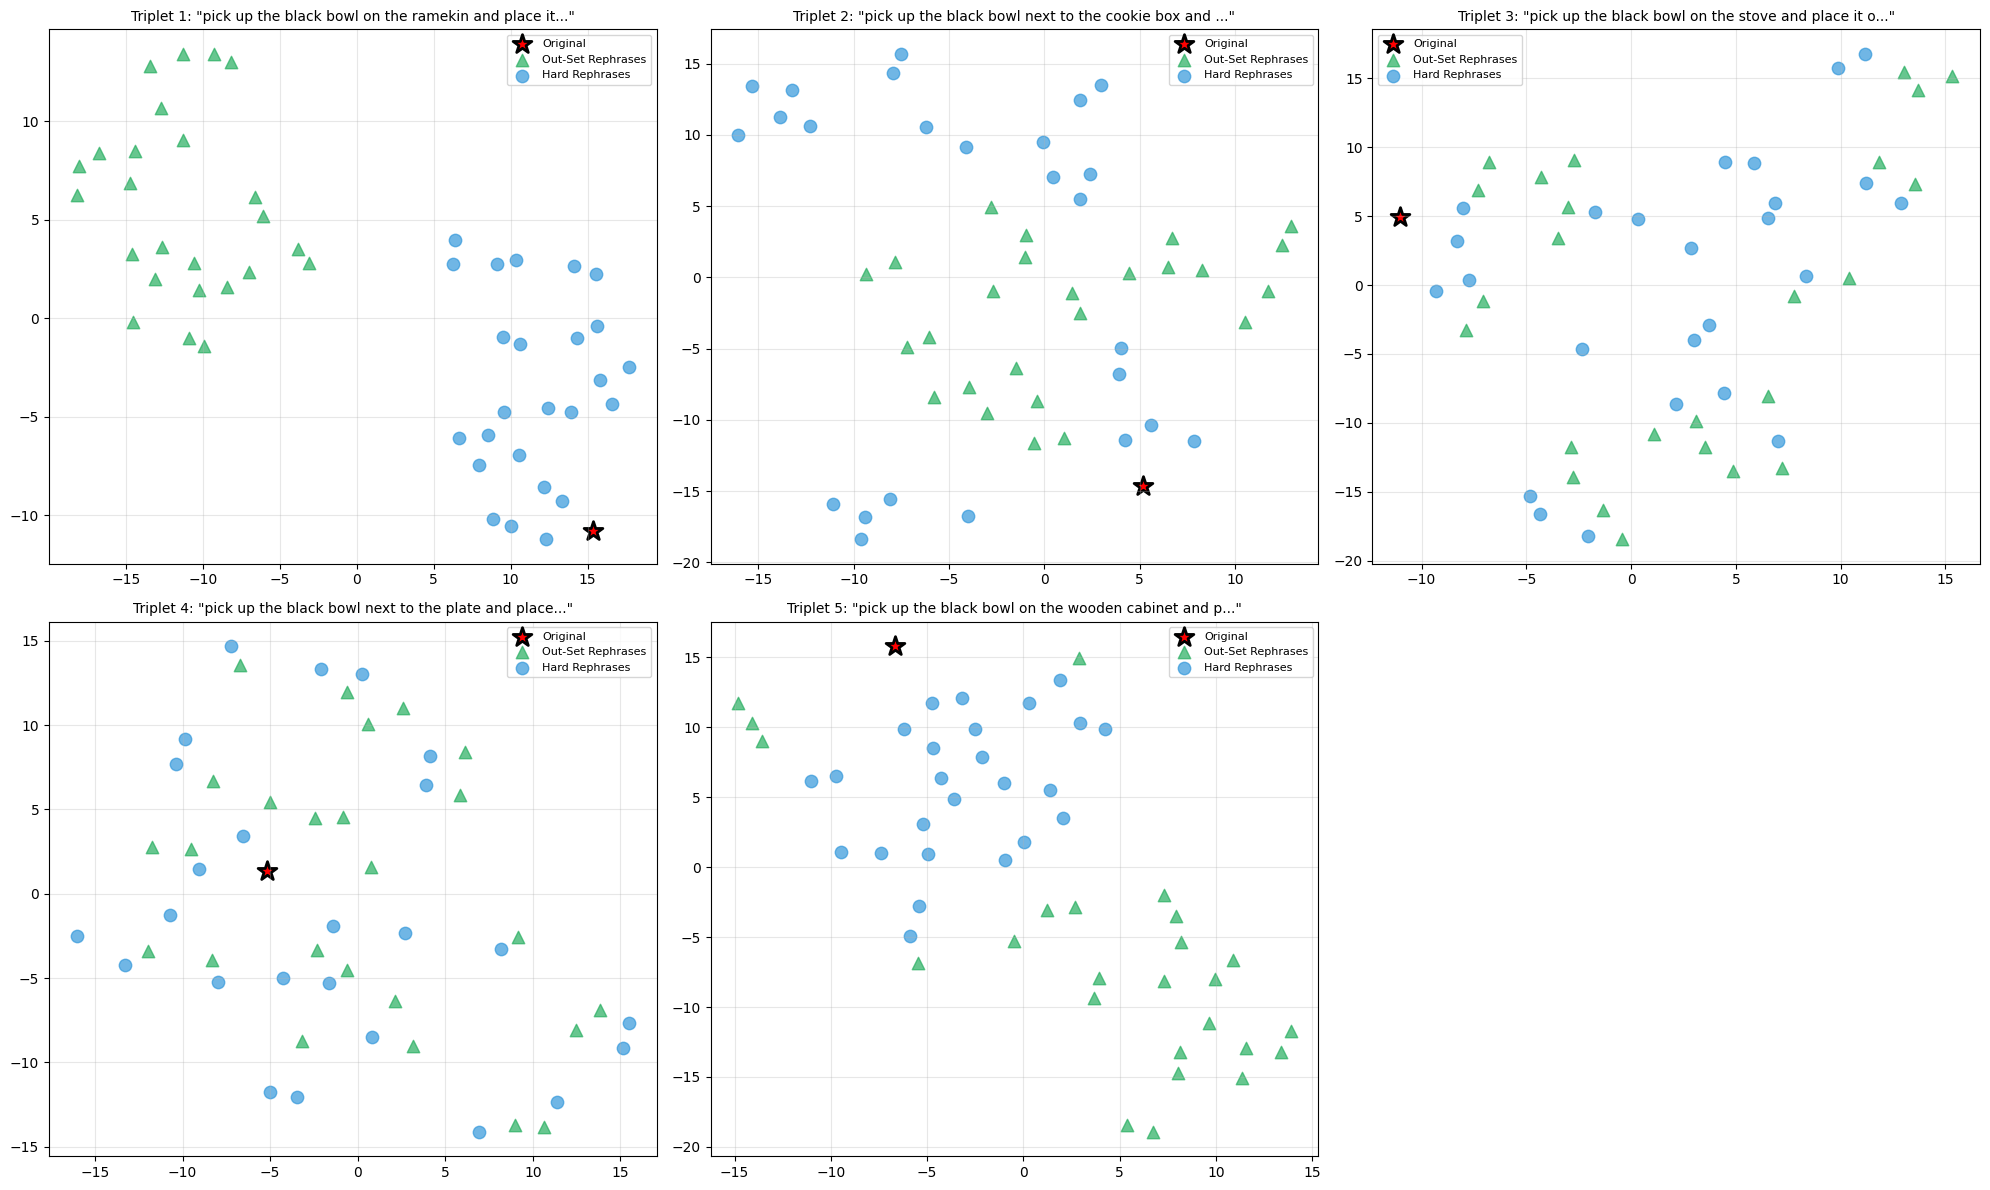

In [6]:
# Show all 5 rollout task three-way pairs
num_pairs_to_show = len(three_way_pairs)  # Should be 5
print(f"Showing all {num_pairs_to_show} rollout task three-way pairs...")

# Create layout for 5 plots (2x3 grid, last spot empty)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i in range(num_pairs_to_show):
    orig, out_set_reps, hard_reps = three_way_pairs[i]
    
    # Get embeddings for this three-way pair
    orig_emb = get_bert_embedding(orig)
    out_set_embs = np.stack([get_bert_embedding(r) for r in out_set_reps])
    hard_embs = np.stack([get_bert_embedding(r) for r in hard_reps])
    
    # Combine for t-SNE
    pair_embeddings = np.vstack([orig_emb.reshape(1, -1), out_set_embs, hard_embs])
    
    # Apply t-SNE with adjusted perplexity
    n_samples = 1 + len(out_set_reps) + len(hard_reps)
    perplexity = min(10, (n_samples - 1) // 3) if n_samples > 5 else 2
    
    try:
        tsne_pair = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=500)
        pair_2d = tsne_pair.fit_transform(pair_embeddings)
        
        # Plot
        ax = axes[i]
        # Original (red star)
        ax.scatter(pair_2d[0, 0], pair_2d[0, 1], c='red', s=200, marker='*', 
                  label='Original', edgecolors='black', linewidth=2)
        
        # Out-set rephrases (green triangles)
        out_set_start = 1
        out_set_end = 1 + len(out_set_reps)
        ax.scatter(pair_2d[out_set_start:out_set_end, 0], pair_2d[out_set_start:out_set_end, 1], 
                  c='#27AE60', s=80, alpha=0.7, marker='^', label='Out-Set Rephrases')
        
        # Hard rephrases (blue circles)
        hard_start = out_set_end
        ax.scatter(pair_2d[hard_start:, 0], pair_2d[hard_start:, 1], 
                  c='#3498DB', s=80, alpha=0.7, marker='o', label='Hard Rephrases')
        
        ax.set_title(f'Triplet {i+1}: "{orig[:50]}..."', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
    except Exception as e:
        ax = axes[i]
        ax.text(0.5, 0.5, f'Error in t-SNE\nfor triplet {i+1}\n{str(e)[:30]}...', 
               ha='center', va='center', transform=ax.transAxes, fontsize=8)
        ax.set_title(f'Triplet {i+1}: Error', fontsize=10)

# Hide the last empty subplot if we have 5 tasks
if num_pairs_to_show == 5:
    axes[5].set_visible(False)

plt.tight_layout()
plt.show()


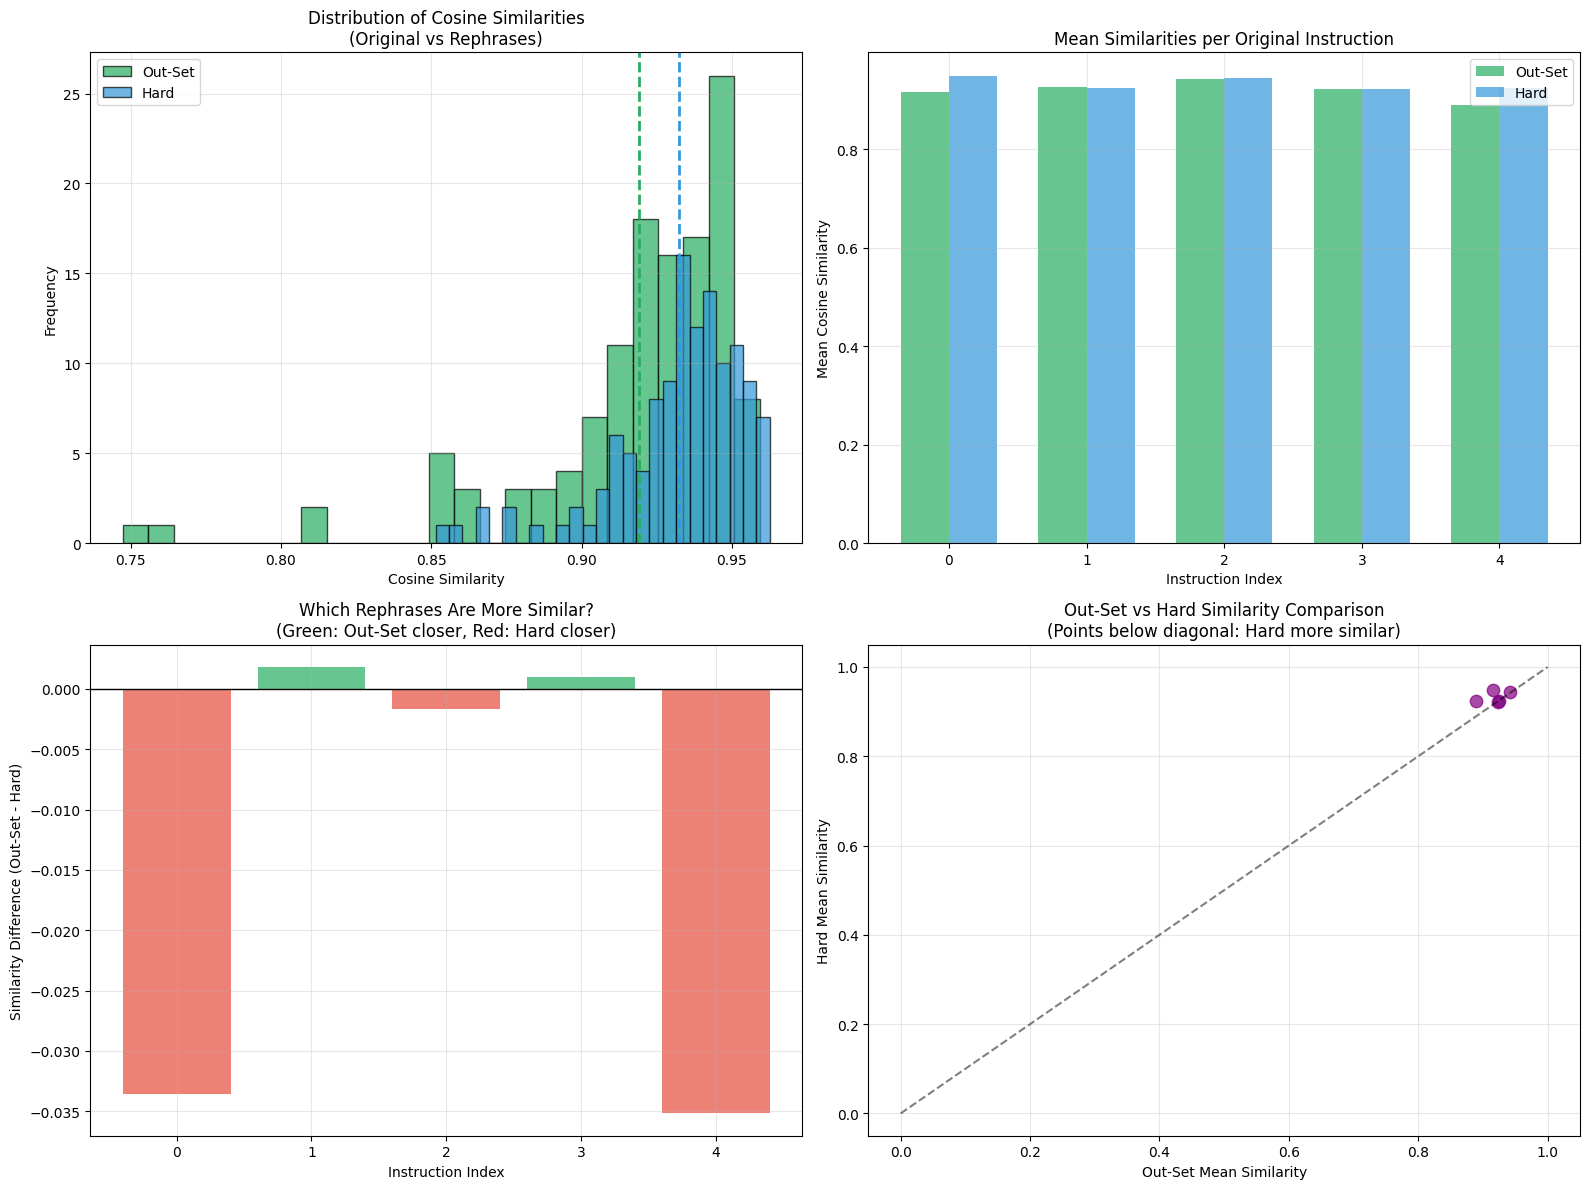

=== COMPREHENSIVE SIMILARITY ANALYSIS ===

📊 OUT-SET REPHRASES:
   Mean similarity: 0.919
   Std similarity: 0.036
   Min similarity: 0.747
   Max similarity: 0.959

📊 HARD REPHRASES:
   Mean similarity: 0.933
   Std similarity: 0.022
   Min similarity: 0.851
   Max similarity: 0.963

🔍 COMPARISON:
   Hard rephrases are MORE similar to originals by 0.014
   Instructions where out-set is closer: 2/5
   Instructions where hard is closer: 3/5

📈 VARIABILITY:
   Out-set consistency (lower std = more consistent): 0.028
   Hard consistency (lower std = more consistent): 0.017


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarities between originals and both types of rephrases
out_set_similarities = []
hard_similarities = []
three_way_analysis = []

for i, (orig, out_set_reps, hard_reps) in enumerate(three_way_pairs):
    orig_emb = get_bert_embedding(orig)
    
    # Compute similarities for out-set rephrases
    out_set_sims = []
    for rep in out_set_reps:
        rep_emb = get_bert_embedding(rep)
        sim = cosine_similarity([orig_emb], [rep_emb])[0, 0]
        out_set_similarities.append(sim)
        out_set_sims.append(sim)
    
    # Compute similarities for hard rephrases
    hard_sims = []
    for rep in hard_reps:
        rep_emb = get_bert_embedding(rep)
        sim = cosine_similarity([orig_emb], [rep_emb])[0, 0]
        hard_similarities.append(sim)
        hard_sims.append(sim)
    
    three_way_analysis.append({
        'original': orig,
        'out_set_similarities': out_set_sims,
        'hard_similarities': hard_sims,
        'out_set_mean': np.mean(out_set_sims),
        'hard_mean': np.mean(hard_sims),
        'out_set_std': np.std(out_set_sims),
        'hard_std': np.std(hard_sims),
        'difference': np.mean(out_set_sims) - np.mean(hard_sims)  # Positive means out-set is more similar
    })

# Create comprehensive similarity plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution comparison
ax1 = axes[0, 0]
ax1.hist(out_set_similarities, bins=25, alpha=0.7, color='#27AE60', label='Out-Set', edgecolor='black')
ax1.hist(hard_similarities, bins=25, alpha=0.7, color='#3498DB', label='Hard', edgecolor='black')
ax1.axvline(np.mean(out_set_similarities), color='#27AE60', linestyle='--', linewidth=2)
ax1.axvline(np.mean(hard_similarities), color='#3498DB', linestyle='--', linewidth=2)
ax1.set_xlabel('Cosine Similarity')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Cosine Similarities\n(Original vs Rephrases)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Mean similarities per instruction
ax2 = axes[0, 1]
out_set_means = [item['out_set_mean'] for item in three_way_analysis]
hard_means = [item['hard_mean'] for item in three_way_analysis]
x_pos = np.arange(len(out_set_means))
width = 0.35

ax2.bar(x_pos - width/2, out_set_means, width, label='Out-Set', color='#27AE60', alpha=0.7)
ax2.bar(x_pos + width/2, hard_means, width, label='Hard', color='#3498DB', alpha=0.7)
ax2.set_xlabel('Instruction Index')
ax2.set_ylabel('Mean Cosine Similarity')
ax2.set_title('Mean Similarities per Original Instruction')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Difference analysis (Out-set - Hard)
ax3 = axes[1, 0]
differences = [item['difference'] for item in three_way_analysis]
colors = ['#27AE60' if d > 0 else '#E74C3C' for d in differences]
bars = ax3.bar(range(len(differences)), differences, color=colors, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.set_xlabel('Instruction Index')
ax3.set_ylabel('Similarity Difference (Out-Set - Hard)')
ax3.set_title('Which Rephrases Are More Similar?\n(Green: Out-Set closer, Red: Hard closer)')
ax3.grid(True, alpha=0.3)

# 4. Scatter plot comparison
ax4 = axes[1, 1]
ax4.scatter(out_set_means, hard_means, alpha=0.7, s=80, color='purple')
ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # Diagonal line
ax4.set_xlabel('Out-Set Mean Similarity')
ax4.set_ylabel('Hard Mean Similarity')
ax4.set_title('Out-Set vs Hard Similarity Comparison\n(Points below diagonal: Hard more similar)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comprehensive statistics
print("=== COMPREHENSIVE SIMILARITY ANALYSIS ===")
print(f"\n📊 OUT-SET REPHRASES:")
print(f"   Mean similarity: {np.mean(out_set_similarities):.3f}")
print(f"   Std similarity: {np.std(out_set_similarities):.3f}")
print(f"   Min similarity: {np.min(out_set_similarities):.3f}")
print(f"   Max similarity: {np.max(out_set_similarities):.3f}")

print(f"\n📊 HARD REPHRASES:")
print(f"   Mean similarity: {np.mean(hard_similarities):.3f}")
print(f"   Std similarity: {np.std(hard_similarities):.3f}")
print(f"   Min similarity: {np.min(hard_similarities):.3f}")
print(f"   Max similarity: {np.max(hard_similarities):.3f}")

print(f"\n🔍 COMPARISON:")
difference = np.mean(out_set_similarities) - np.mean(hard_similarities)
if difference > 0:
    print(f"   Out-set rephrases are MORE similar to originals by {difference:.3f}")
else:
    print(f"   Hard rephrases are MORE similar to originals by {abs(difference):.3f}")

# Count how many instructions favor each type
out_set_wins = sum(1 for item in three_way_analysis if item['difference'] > 0)
hard_wins = len(three_way_analysis) - out_set_wins
print(f"   Instructions where out-set is closer: {out_set_wins}/{len(three_way_analysis)}")
print(f"   Instructions where hard is closer: {hard_wins}/{len(three_way_analysis)}")

print(f"\n📈 VARIABILITY:")
print(f"   Out-set consistency (lower std = more consistent): {np.mean([item['out_set_std'] for item in three_way_analysis]):.3f}")
print(f"   Hard consistency (lower std = more consistent): {np.mean([item['hard_std'] for item in three_way_analysis]):.3f}")


In [8]:
# Simple analysis: Oracle Rollouts rephrase_25 Success Rate vs Average Embedding Distance
import os
import re
from collections import defaultdict

def parse_oracle_rephrase_25(rollouts_dir='/root/vla-clip/openvla/rollouts_ood_oracle/rephrase_25'):
    """Parse rephrase_25 directory to extract success rates per task."""
    print("Parsing oracle rephrase_25 rollouts...")
    task_results = defaultdict(list)
    
    # Parse each episode file
    for filename in os.listdir(rollouts_dir):
        if filename.endswith('.pkl'):
            # Extract info from filename: episode=X--success=True/False--score=X.X--task=TASK_NAME.pkl
            match = re.match(r'episode=(\d+)--success=(True|False)--score=([\d\.-]+)--task=(.+)\.pkl', filename)
            if match:
                episode, success, score, task = match.groups()
                task = task.replace('_', ' ')  # Convert underscores to spaces
                success_bool = success == 'True'
                task_results[task].append(success_bool)
    
    # Calculate success rates per task
    task_success_rates = {}
    for task, successes in task_results.items():
        success_rate = sum(successes) / len(successes) if successes else 0
        task_success_rates[task] = {
            'success_rate': success_rate,
            'total_episodes': len(successes),
            'successful_episodes': sum(successes)
        }
    
    return task_success_rates

# Parse the oracle rephrase_25 data
oracle_results = parse_oracle_rephrase_25()

print(f"Found {len(oracle_results)} unique tasks in oracle rephrase_25:")
for task, stats in oracle_results.items():
    print(f"   {task}: {stats['success_rate']:.1%} ({stats['successful_episodes']}/{stats['total_episodes']})")


Parsing oracle rephrase_25 rollouts...
Found 5 unique tasks in oracle rephrase_25:
   pick up the black bowl on the ramekin and place it on the plate: 75.0% (15/20)
   pick up the black bowl next to the cookie box and place it on the plate: 85.0% (17/20)
   pick up the black bowl on the stove and place it on the plate: 55.0% (11/20)
   pick up the black bowl next to the plate and place it on the plate: 80.0% (16/20)
   pick up the black bowl on the wooden cabinet and place it on the plate: 20.0% (4/20)


In [9]:
# Match oracle tasks with our embedding analysis and create the correlation plot
def normalize_task_name(task):
    """Normalize task names for matching between datasets."""
    return re.sub(r'\s+', ' ', task.strip().lower())

# Create mapping between embedding data and oracle success rates
print("\nMatching embedding data with oracle success rates...")

# Normalize our original instructions for matching
normalized_originals = {}
for i, orig in enumerate(originals):
    normalized = normalize_task_name(orig)
    normalized_originals[normalized] = i

# Extract data for tasks that match both datasets
matched_tasks = []
for task, stats in oracle_results.items():
    normalized_task = normalize_task_name(task)
    
    if normalized_task in normalized_originals:
        orig_idx = normalized_originals[normalized_task]
        task_analysis = three_way_analysis[orig_idx]
        
        # Calculate average and minimum embedding distances
        avg_distance = (task_analysis['out_set_mean'] + task_analysis['hard_mean']) / 2
        avg_distance_converted = 1 - avg_distance  # Convert similarity to distance
        
        # Minimum distance = best (highest similarity) of the two types
        min_distance = min(1 - task_analysis['out_set_mean'], 1 - task_analysis['hard_mean'])
        
        matched_tasks.append({
            'task': originals[orig_idx],
            'success_rate': stats['success_rate'],
            'total_episodes': stats['total_episodes'],
            'avg_embedding_distance': avg_distance_converted,
            'min_embedding_distance': min_distance,
            'out_set_distance': 1 - task_analysis['out_set_mean'],
            'hard_distance': 1 - task_analysis['hard_mean']
        })

print(f"✅ Successfully matched {len(matched_tasks)} tasks")

# Display matched data
print(f"\n📄 Matched tasks data:")
for task_data in matched_tasks:
    print(f"   {task_data['task'][:50]}...")
    print(f"      Success Rate: {task_data['success_rate']:.1%}")
    print(f"      Avg Embedding Distance: {task_data['avg_embedding_distance']:.3f}")
    print(f"      Min Embedding Distance: {task_data['min_embedding_distance']:.3f}")
    print(f"      Episodes: {task_data['total_episodes']}")
    print()



Matching embedding data with oracle success rates...
✅ Successfully matched 5 tasks

📄 Matched tasks data:
   pick up the black bowl on the ramekin and place it...
      Success Rate: 75.0%
      Avg Embedding Distance: 0.068
      Min Embedding Distance: 0.051
      Episodes: 20

   pick up the black bowl next to the cookie box and ...
      Success Rate: 85.0%
      Avg Embedding Distance: 0.076
      Min Embedding Distance: 0.075
      Episodes: 20

   pick up the black bowl on the stove and place it o...
      Success Rate: 55.0%
      Avg Embedding Distance: 0.057
      Min Embedding Distance: 0.057
      Episodes: 20

   pick up the black bowl next to the plate and place...
      Success Rate: 80.0%
      Avg Embedding Distance: 0.078
      Min Embedding Distance: 0.077
      Episodes: 20

   pick up the black bowl on the wooden cabinet and p...
      Success Rate: 20.0%
      Avg Embedding Distance: 0.093
      Min Embedding Distance: 0.075
      Episodes: 20



Creating Success Rate vs Embedding Distance plots (Average and Minimum)...


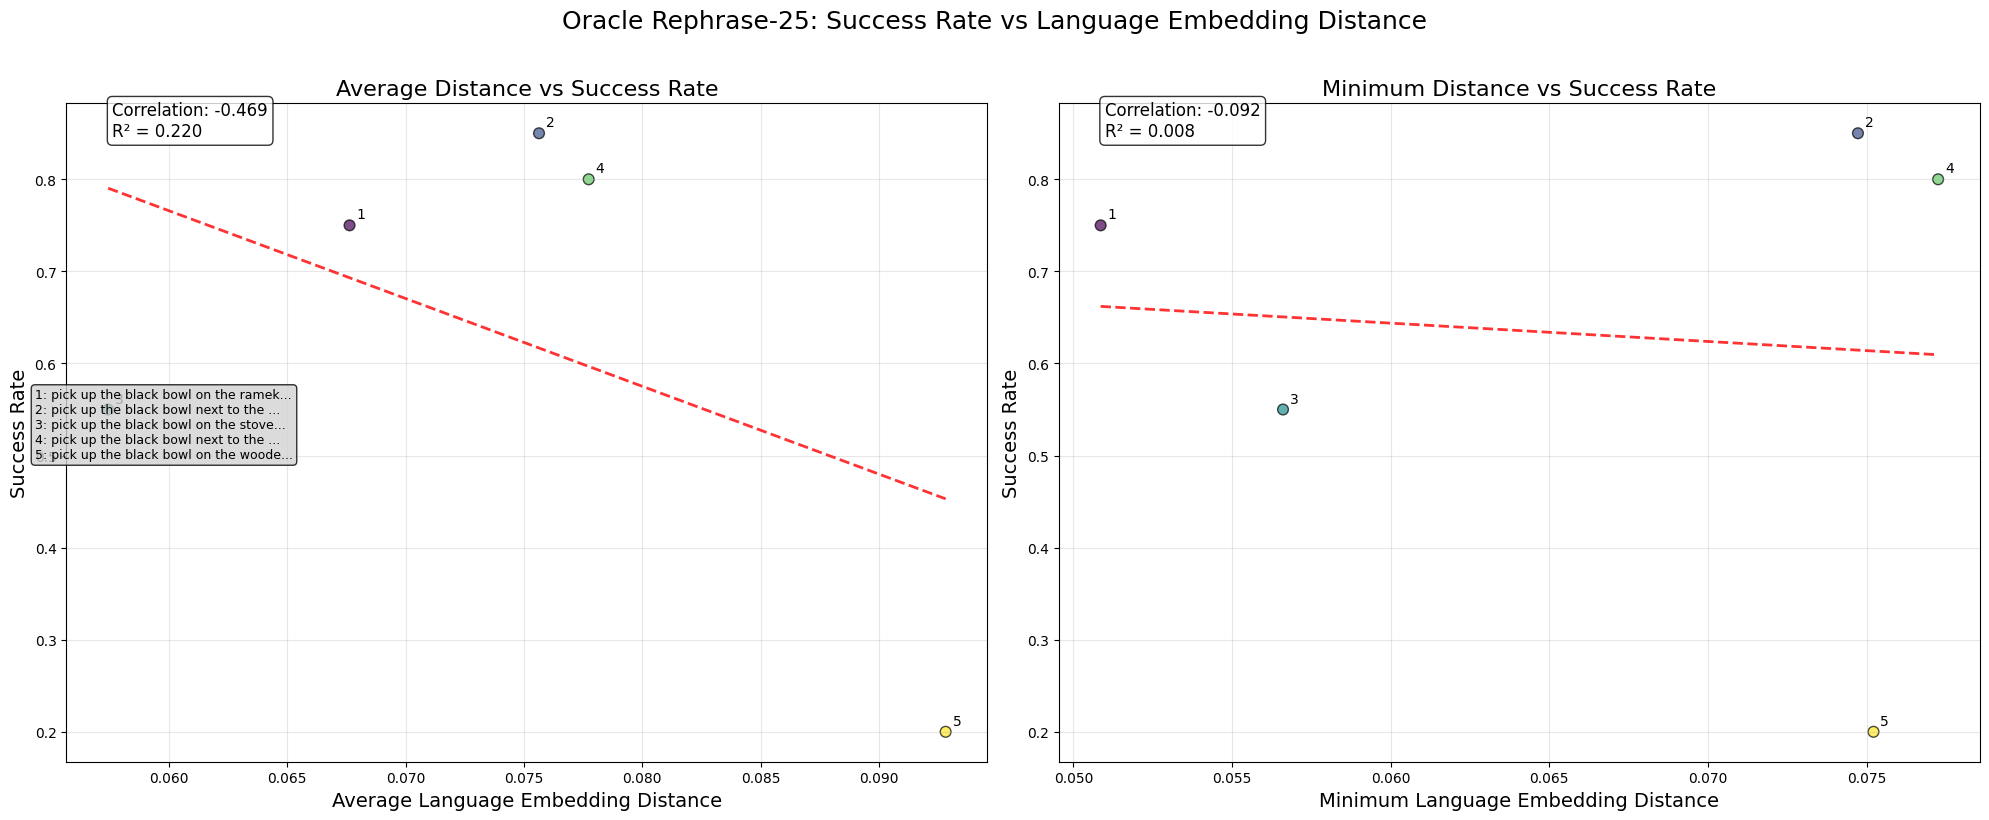


🔍 CORRELATION ANALYSIS:
   📊 Tasks analyzed: 5

📈 AVERAGE DISTANCE vs SUCCESS RATE:
   Correlation coefficient: -0.469
   R-squared: 0.220
   ⚠️  NEGATIVE correlation: Higher avg distance → Lower success rate

📉 MINIMUM DISTANCE vs SUCCESS RATE:
   Correlation coefficient: -0.092
   R-squared: 0.008
   ⚠️  NEGATIVE correlation: Higher min distance → Lower success rate

🎯 BETTER PREDICTOR: Average distance (|-0.469| > |-0.092|)
   📝 Interpretation: Overall semantic similarity is more predictive than best-case

📋 DETAILED TASK SUMMARY:
   1. pick up the black bowl on the ramekin and place it on the plate
      Success: 75.0%
      Avg Distance: 0.068
      Min Distance: 0.051
   2. pick up the black bowl next to the cookie box and place it on the plate
      Success: 85.0%
      Avg Distance: 0.076
      Min Distance: 0.075
   3. pick up the black bowl on the stove and place it on the plate
      Success: 55.0%
      Avg Distance: 0.057
      Min Distance: 0.057
   4. pick up the black 

In [10]:
# Create dual plots: Success Rate vs Average and Minimum Language Embedding Distance
print("Creating Success Rate vs Embedding Distance plots (Average and Minimum)...")

# Extract data for plotting
success_rates = [task['success_rate'] for task in matched_tasks]
avg_distances = [task['avg_embedding_distance'] for task in matched_tasks]
min_distances = [task['min_embedding_distance'] for task in matched_tasks]
task_names = [task['task'] for task in matched_tasks]
total_episodes = [task['total_episodes'] for task in matched_tasks]

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Average Distance vs Success Rate
scatter1 = ax1.scatter(avg_distances, success_rates, 
                      s=[ep * 3 for ep in total_episodes],
                      alpha=0.7, 
                      c=range(len(matched_tasks)), 
                      cmap='viridis',
                      edgecolors='black',
                      linewidth=1)

# Add trend line for average distance
if len(avg_distances) > 1:
    corr_avg = np.corrcoef(avg_distances, success_rates)[0, 1]
    z_avg = np.polyfit(avg_distances, success_rates, 1)
    p_avg = np.poly1d(z_avg)
    x_trend_avg = np.linspace(min(avg_distances), max(avg_distances), 100)
    ax1.plot(x_trend_avg, p_avg(x_trend_avg), "r--", alpha=0.8, linewidth=2)
    
    ax1.text(0.05, 0.95, f'Correlation: {corr_avg:.3f}\nR² = {corr_avg**2:.3f}', 
             transform=ax1.transAxes, 
             bbox=dict(boxstyle="round", facecolor='white', alpha=0.8),
             fontsize=12)

ax1.set_xlabel('Average Language Embedding Distance', fontsize=14)
ax1.set_ylabel('Success Rate', fontsize=14)
ax1.set_title('Average Distance vs Success Rate', fontsize=16)
ax1.grid(True, alpha=0.3)

# Add task labels for plot 1
for i, (x, y) in enumerate(zip(avg_distances, success_rates)):
    ax1.annotate(f'{i+1}', (x, y), xytext=(5, 5), textcoords='offset points', 
                fontsize=10, ha='left')

# Plot 2: Minimum Distance vs Success Rate
scatter2 = ax2.scatter(min_distances, success_rates, 
                      s=[ep * 3 for ep in total_episodes],
                      alpha=0.7, 
                      c=range(len(matched_tasks)), 
                      cmap='viridis',
                      edgecolors='black',
                      linewidth=1)

# Add trend line for minimum distance
if len(min_distances) > 1:
    corr_min = np.corrcoef(min_distances, success_rates)[0, 1]
    z_min = np.polyfit(min_distances, success_rates, 1)
    p_min = np.poly1d(z_min)
    x_trend_min = np.linspace(min(min_distances), max(min_distances), 100)
    ax2.plot(x_trend_min, p_min(x_trend_min), "r--", alpha=0.8, linewidth=2)
    
    ax2.text(0.05, 0.95, f'Correlation: {corr_min:.3f}\nR² = {corr_min**2:.3f}', 
             transform=ax2.transAxes, 
             bbox=dict(boxstyle="round", facecolor='white', alpha=0.8),
             fontsize=12)

ax2.set_xlabel('Minimum Language Embedding Distance', fontsize=14)
ax2.set_ylabel('Success Rate', fontsize=14)
ax2.set_title('Minimum Distance vs Success Rate', fontsize=16)
ax2.grid(True, alpha=0.3)

# Add task labels for plot 2
for i, (x, y) in enumerate(zip(min_distances, success_rates)):
    ax2.annotate(f'{i+1}', (x, y), xytext=(5, 5), textcoords='offset points', 
                fontsize=10, ha='left')

# Add overall title
fig.suptitle('Oracle Rephrase-25: Success Rate vs Language Embedding Distance', fontsize=18, y=1.02)

# Add shared colorbar
# cbar = fig.colorbar(scatter1, ax=[ax1, ax2], location='bottom', pad=0.1)
# cbar.set_label('Task Index', fontsize=12)

# Add legend for task numbers
legend_text = "\n".join([f"{i+1}: {task[:35]}{'...' if len(task) > 35 else ''}" 
                        for i, task in enumerate(task_names)])
fig.text(0.02, 0.5, legend_text, fontsize=9, ha='left', va='center',
         bbox=dict(boxstyle="round", facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

# Print correlation statistics for both
print(f"\n🔍 CORRELATION ANALYSIS:")
print(f"   📊 Tasks analyzed: {len(matched_tasks)}")

print(f"\n📈 AVERAGE DISTANCE vs SUCCESS RATE:")
print(f"   Correlation coefficient: {corr_avg:.3f}")
print(f"   R-squared: {corr_avg**2:.3f}")
if corr_avg > 0:
    print(f"   ✅ POSITIVE correlation: Higher avg distance → Higher success rate")
else:
    print(f"   ⚠️  NEGATIVE correlation: Higher avg distance → Lower success rate")

print(f"\n📉 MINIMUM DISTANCE vs SUCCESS RATE:")
print(f"   Correlation coefficient: {corr_min:.3f}")
print(f"   R-squared: {corr_min**2:.3f}")
if corr_min > 0:
    print(f"   ✅ POSITIVE correlation: Higher min distance → Higher success rate")
else:
    print(f"   ⚠️  NEGATIVE correlation: Higher min distance → Lower success rate")

# Compare which is a better predictor
if abs(corr_min) > abs(corr_avg):
    print(f"\n🎯 BETTER PREDICTOR: Minimum distance (|{corr_min:.3f}| > |{corr_avg:.3f}|)")
    print(f"   📝 Interpretation: Best-case semantic similarity is more predictive than average")
else:
    print(f"\n🎯 BETTER PREDICTOR: Average distance (|{corr_avg:.3f}| > |{corr_min:.3f}|)")
    print(f"   📝 Interpretation: Overall semantic similarity is more predictive than best-case")

print(f"\n📋 DETAILED TASK SUMMARY:")
for i, task_data in enumerate(matched_tasks):
    print(f"   {i+1}. {task_data['task']}")
    print(f"      Success: {task_data['success_rate']:.1%}")
    print(f"      Avg Distance: {task_data['avg_embedding_distance']:.3f}")
    print(f"      Min Distance: {task_data['min_embedding_distance']:.3f}")

print(f"\n💡 INTERPRETATION:")
print(f"   • Point size represents number of episodes ({min(total_episodes)}-{max(total_episodes)})")
print(f"   • Lower embedding distance = More similar to original instruction")
print(f"   • Average distance = Mean of hard and out-set rephrase distances")
print(f"   • Minimum distance = Best (lowest) distance from either rephrase type")
print(f"   • This comparison shows whether best-case or average similarity matters more")


In [11]:
# Calculate diversity metrics for each task's rephrases
print("Calculating rephrase diversity metrics...")

# Enhance matched_tasks with diversity metrics
for i, task_data in enumerate(matched_tasks):
    orig_idx = normalized_originals[normalize_task_name(task_data['task'])]
    task_analysis = three_way_analysis[orig_idx]
    
    # Get embedding distances for all rephrases of this task
    out_set_distances = [1 - sim for sim in task_analysis['out_set_similarities']]
    hard_distances = [1 - sim for sim in task_analysis['hard_similarities']]
    all_distances = out_set_distances + hard_distances
    
    # Calculate diversity metrics
    distance_std = np.std(all_distances)  # Standard deviation of distances
    distance_range = max(all_distances) - min(all_distances)  # Range of distances
    cross_type_diversity = abs(task_data['out_set_distance'] - task_data['hard_distance'])  # Distance between hard/out-set means
    
    # Add to task data
    task_data['distance_diversity'] = distance_std
    task_data['distance_range'] = distance_range
    task_data['cross_type_diversity'] = cross_type_diversity
    task_data['total_rephrases'] = len(all_distances)

print("✅ Diversity metrics calculated for all tasks")

# Display diversity data
print(f"\n📊 DIVERSITY METRICS SUMMARY:")
for i, task_data in enumerate(matched_tasks):
    print(f"   {i+1}. {task_data['task'][:50]}...")
    print(f"      Success Rate: {task_data['success_rate']:.1%}")
    print(f"      Distance Std Dev: {task_data['distance_diversity']:.4f}")
    print(f"      Distance Range: {task_data['distance_range']:.4f}")
    print(f"      Cross-type Diversity: {task_data['cross_type_diversity']:.4f}")
    print(f"      Total Rephrases: {task_data['total_rephrases']}")
    print()

# Extract diversity metrics for plotting
diversity_metrics = [task['distance_diversity'] for task in matched_tasks]
range_metrics = [task['distance_range'] for task in matched_tasks]
cross_type_metrics = [task['cross_type_diversity'] for task in matched_tasks]
success_rates = [task['success_rate'] for task in matched_tasks]
task_names = [task['task'] for task in matched_tasks]
total_episodes = [task['total_episodes'] for task in matched_tasks]


Calculating rephrase diversity metrics...
✅ Diversity metrics calculated for all tasks

📊 DIVERSITY METRICS SUMMARY:
   1. pick up the black bowl on the ramekin and place it...
      Success Rate: 75.0%
      Distance Std Dev: 0.0337
      Distance Range: 0.1510
      Cross-type Diversity: 0.0336
      Total Rephrases: 50

   2. pick up the black bowl next to the cookie box and ...
      Success Rate: 85.0%
      Distance Std Dev: 0.0229
      Distance Range: 0.1091
      Cross-type Diversity: 0.0018
      Total Rephrases: 50

   3. pick up the black bowl on the stove and place it o...
      Success Rate: 55.0%
      Distance Std Dev: 0.0104
      Distance Range: 0.0572
      Cross-type Diversity: 0.0017
      Total Rephrases: 50

   4. pick up the black bowl next to the plate and place...
      Success Rate: 80.0%
      Distance Std Dev: 0.0247
      Distance Range: 0.1027
      Cross-type Diversity: 0.0010
      Total Rephrases: 50

   5. pick up the black bowl on the wooden cabinet 

Creating Diversity vs Success Rate plots...


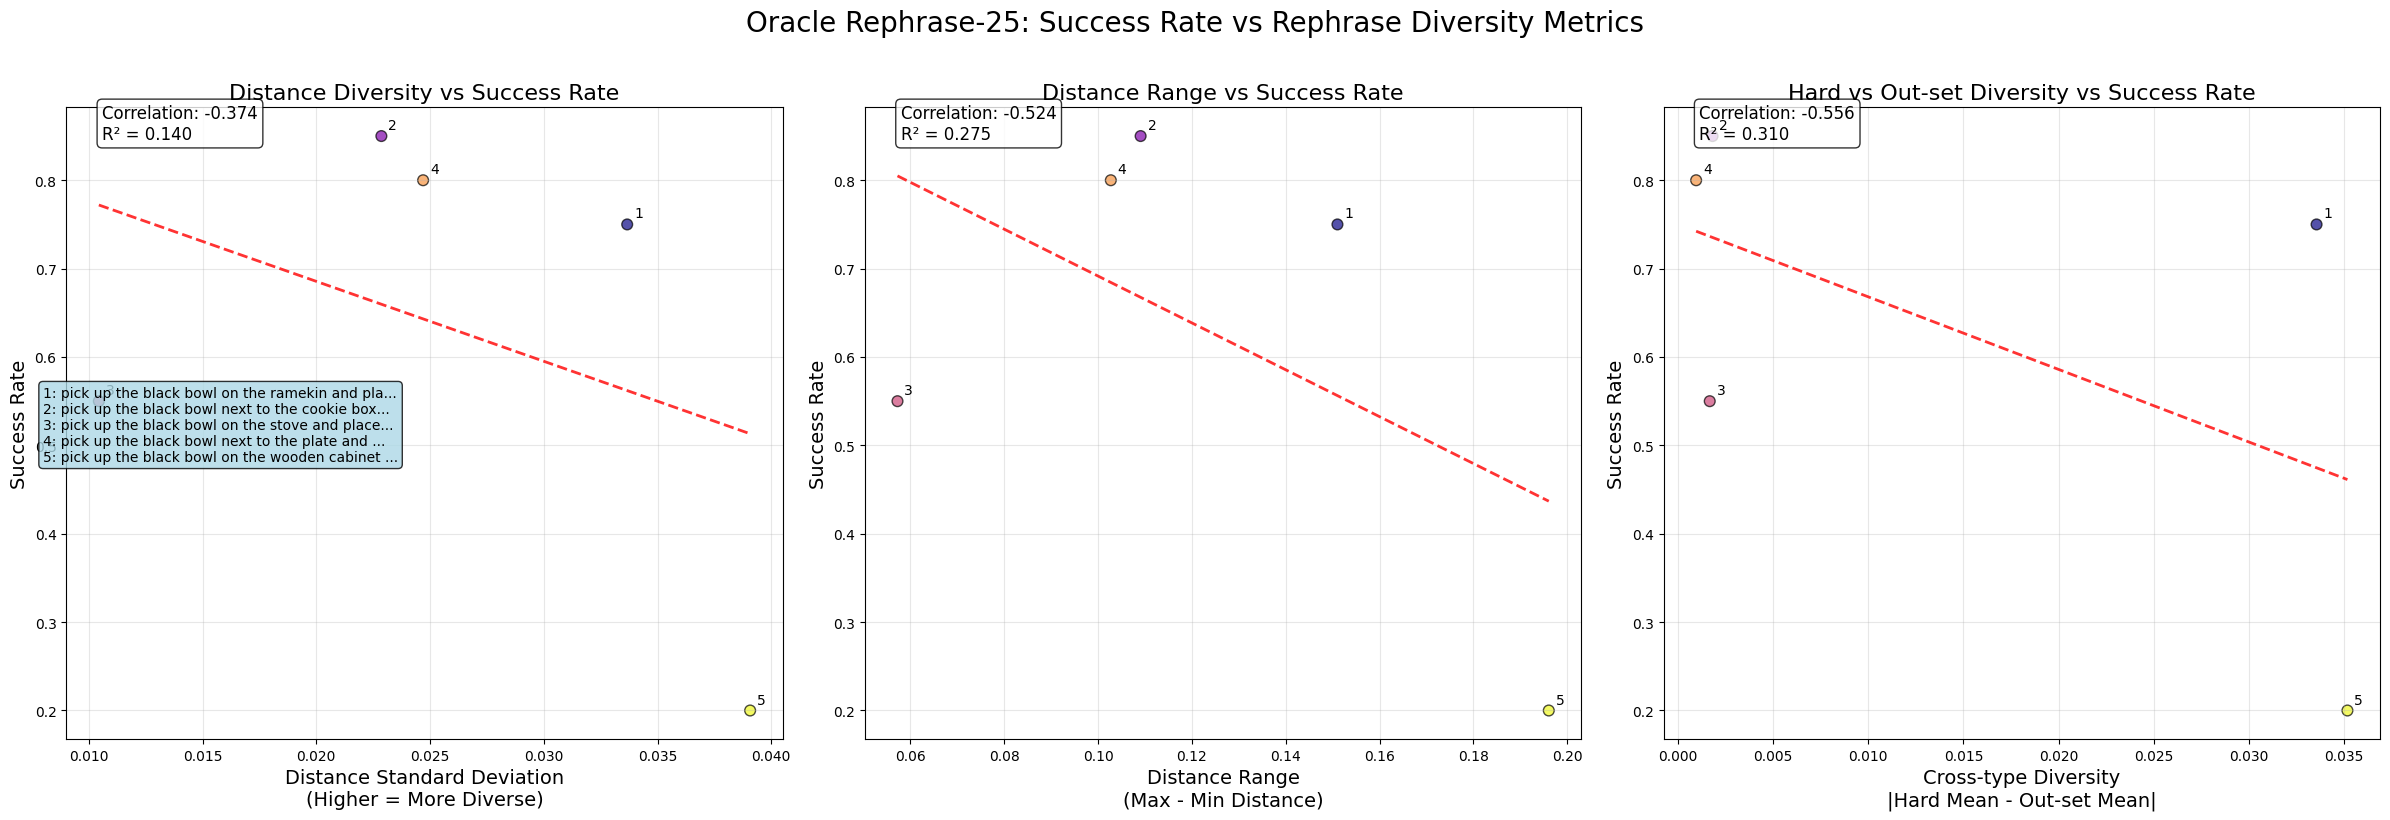


🎯 DIVERSITY vs SUCCESS RATE ANALYSIS:
   📊 Tasks analyzed: 5

📈 DISTANCE DIVERSITY (Standard Deviation) vs SUCCESS RATE:
   Correlation coefficient: -0.374
   R-squared: 0.140
   ⚠️  NEGATIVE correlation: Higher diversity → Lower success rate
   📝 Interpretation: More consistent rephrases help robot performance

📉 DISTANCE RANGE vs SUCCESS RATE:
   Correlation coefficient: -0.524
   R-squared: 0.275
   ⚠️  NEGATIVE correlation: Larger range → Lower success rate

🔄 CROSS-TYPE DIVERSITY vs SUCCESS RATE:
   Correlation coefficient: -0.556
   R-squared: 0.310
   ⚠️  NEGATIVE correlation: More difference between hard/out-set → Lower success

🏆 STRONGEST DIVERSITY PREDICTOR: Cross-type Diversity (|0.556|)

💡 PRACTICAL IMPLICATIONS:
   🎯 Training Strategy: Focus on consistent, semantically tight rephrases
   📝 Avoid: High variance in rephrase semantic distances

📋 DETAILED DIVERSITY BREAKDOWN:
   1. Success: 75.0%
      Diversity (std): 0.0337
      Range: 0.1510
      Cross-type: 0.0336
   

In [12]:
# Create comprehensive diversity vs success rate plots
print("Creating Diversity vs Success Rate plots...")

# Create triple plots: three different diversity metrics
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot 1: Distance Standard Deviation vs Success Rate
scatter1 = ax1.scatter(diversity_metrics, success_rates, 
                      s=[ep * 3 for ep in total_episodes],
                      alpha=0.7, 
                      c=range(len(matched_tasks)), 
                      cmap='plasma',
                      edgecolors='black',
                      linewidth=1)

# Add trend line for distance diversity
if len(diversity_metrics) > 1:
    corr_div = np.corrcoef(diversity_metrics, success_rates)[0, 1]
    z_div = np.polyfit(diversity_metrics, success_rates, 1)
    p_div = np.poly1d(z_div)
    x_trend_div = np.linspace(min(diversity_metrics), max(diversity_metrics), 100)
    ax1.plot(x_trend_div, p_div(x_trend_div), "r--", alpha=0.8, linewidth=2)
    
    ax1.text(0.05, 0.95, f'Correlation: {corr_div:.3f}\nR² = {corr_div**2:.3f}', 
             transform=ax1.transAxes, 
             bbox=dict(boxstyle="round", facecolor='white', alpha=0.8),
             fontsize=12)

ax1.set_xlabel('Distance Standard Deviation\n(Higher = More Diverse)', fontsize=14)
ax1.set_ylabel('Success Rate', fontsize=14)
ax1.set_title('Distance Diversity vs Success Rate', fontsize=16)
ax1.grid(True, alpha=0.3)

# Add task labels for plot 1
for i, (x, y) in enumerate(zip(diversity_metrics, success_rates)):
    ax1.annotate(f'{i+1}', (x, y), xytext=(5, 5), textcoords='offset points', 
                fontsize=10, ha='left')

# Plot 2: Distance Range vs Success Rate
scatter2 = ax2.scatter(range_metrics, success_rates, 
                      s=[ep * 3 for ep in total_episodes],
                      alpha=0.7, 
                      c=range(len(matched_tasks)), 
                      cmap='plasma',
                      edgecolors='black',
                      linewidth=1)

# Add trend line for distance range
if len(range_metrics) > 1:
    corr_range = np.corrcoef(range_metrics, success_rates)[0, 1]
    z_range = np.polyfit(range_metrics, success_rates, 1)
    p_range = np.poly1d(z_range)
    x_trend_range = np.linspace(min(range_metrics), max(range_metrics), 100)
    ax2.plot(x_trend_range, p_range(x_trend_range), "r--", alpha=0.8, linewidth=2)
    
    ax2.text(0.05, 0.95, f'Correlation: {corr_range:.3f}\nR² = {corr_range**2:.3f}', 
             transform=ax2.transAxes, 
             bbox=dict(boxstyle="round", facecolor='white', alpha=0.8),
             fontsize=12)

ax2.set_xlabel('Distance Range\n(Max - Min Distance)', fontsize=14)
ax2.set_ylabel('Success Rate', fontsize=14)
ax2.set_title('Distance Range vs Success Rate', fontsize=16)
ax2.grid(True, alpha=0.3)

# Add task labels for plot 2
for i, (x, y) in enumerate(zip(range_metrics, success_rates)):
    ax2.annotate(f'{i+1}', (x, y), xytext=(5, 5), textcoords='offset points', 
                fontsize=10, ha='left')

# Plot 3: Cross-type Diversity vs Success Rate
scatter3 = ax3.scatter(cross_type_metrics, success_rates, 
                      s=[ep * 3 for ep in total_episodes],
                      alpha=0.7, 
                      c=range(len(matched_tasks)), 
                      cmap='plasma',
                      edgecolors='black',
                      linewidth=1)

# Add trend line for cross-type diversity
if len(cross_type_metrics) > 1:
    corr_cross = np.corrcoef(cross_type_metrics, success_rates)[0, 1]
    z_cross = np.polyfit(cross_type_metrics, success_rates, 1)
    p_cross = np.poly1d(z_cross)
    x_trend_cross = np.linspace(min(cross_type_metrics), max(cross_type_metrics), 100)
    ax3.plot(x_trend_cross, p_cross(x_trend_cross), "r--", alpha=0.8, linewidth=2)
    
    ax3.text(0.05, 0.95, f'Correlation: {corr_cross:.3f}\nR² = {corr_cross**2:.3f}', 
             transform=ax3.transAxes, 
             bbox=dict(boxstyle="round", facecolor='white', alpha=0.8),
             fontsize=12)

ax3.set_xlabel('Cross-type Diversity\n|Hard Mean - Out-set Mean|', fontsize=14)
ax3.set_ylabel('Success Rate', fontsize=14)
ax3.set_title('Hard vs Out-set Diversity vs Success Rate', fontsize=16)
ax3.grid(True, alpha=0.3)

# Add task labels for plot 3
for i, (x, y) in enumerate(zip(cross_type_metrics, success_rates)):
    ax3.annotate(f'{i+1}', (x, y), xytext=(5, 5), textcoords='offset points', 
                fontsize=10, ha='left')

# Add overall title
fig.suptitle('Oracle Rephrase-25: Success Rate vs Rephrase Diversity Metrics', fontsize=20, y=1.02)

# Add legend for task numbers at the bottom
legend_text = "\n".join([f"{i+1}: {task[:45]}{'...' if len(task) > 45 else ''}" 
                        for i, task in enumerate(task_names)])
fig.text(0.02, 0.5, legend_text, fontsize=10, ha='left', va='center',
         bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# Print comprehensive diversity analysis
print(f"\n🎯 DIVERSITY vs SUCCESS RATE ANALYSIS:")
print(f"   📊 Tasks analyzed: {len(matched_tasks)}")

print(f"\n📈 DISTANCE DIVERSITY (Standard Deviation) vs SUCCESS RATE:")
print(f"   Correlation coefficient: {corr_div:.3f}")
print(f"   R-squared: {corr_div**2:.3f}")
if corr_div > 0:
    print(f"   ✅ POSITIVE correlation: Higher diversity → Higher success rate")
    print(f"   📝 Interpretation: More diverse rephrases help robot performance")
else:
    print(f"   ⚠️  NEGATIVE correlation: Higher diversity → Lower success rate")
    print(f"   📝 Interpretation: More consistent rephrases help robot performance")

print(f"\n📉 DISTANCE RANGE vs SUCCESS RATE:")
print(f"   Correlation coefficient: {corr_range:.3f}")
print(f"   R-squared: {corr_range**2:.3f}")
if corr_range > 0:
    print(f"   ✅ POSITIVE correlation: Larger range → Higher success rate")
else:
    print(f"   ⚠️  NEGATIVE correlation: Larger range → Lower success rate")

print(f"\n🔄 CROSS-TYPE DIVERSITY vs SUCCESS RATE:")
print(f"   Correlation coefficient: {corr_cross:.3f}")
print(f"   R-squared: {corr_cross**2:.3f}")
if corr_cross > 0:
    print(f"   ✅ POSITIVE correlation: More difference between hard/out-set → Higher success")
else:
    print(f"   ⚠️  NEGATIVE correlation: More difference between hard/out-set → Lower success")

# Find the strongest diversity predictor
diversity_correlations = {
    'Distance Diversity': abs(corr_div),
    'Distance Range': abs(corr_range),
    'Cross-type Diversity': abs(corr_cross)
}
best_predictor = max(diversity_correlations.keys(), key=lambda k: diversity_correlations[k])
best_corr = diversity_correlations[best_predictor]

print(f"\n🏆 STRONGEST DIVERSITY PREDICTOR: {best_predictor} (|{best_corr:.3f}|)")

print(f"\n💡 PRACTICAL IMPLICATIONS:")
if corr_div < 0:
    print(f"   🎯 Training Strategy: Focus on consistent, semantically tight rephrases")
    print(f"   📝 Avoid: High variance in rephrase semantic distances")
else:
    print(f"   🎯 Training Strategy: Include diverse rephrases with varying semantic distances")
    print(f"   📝 Benefit: Semantic diversity appears to improve robustness")

print(f"\n📋 DETAILED DIVERSITY BREAKDOWN:")
for i, task_data in enumerate(matched_tasks):
    print(f"   {i+1}. Success: {task_data['success_rate']:.1%}")
    print(f"      Diversity (std): {task_data['distance_diversity']:.4f}")
    print(f"      Range: {task_data['distance_range']:.4f}") 
    print(f"      Cross-type: {task_data['cross_type_diversity']:.4f}")
    print(f"      Rephrases: {task_data['total_rephrases']}")
    print()
